# Current speed vs obs

# <font color="#FF0000">FIXME: we calculate magnitude of time-mean velocity which is not the same as time-mean speed. Save speed in diag_table?</font>



In [1]:
%matplotlib inline
import pandas as pd
import intake
catalog = intake.cat.access_nri
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math

import sys, os

os.chdir(os.path.join(os.getcwd(), "ACCESS-OM2-updated/figures/surface_current"))
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [13]:
from dask.distributed import Client
client = Client("tcp://10.6.43.39:8786")
client

<Client: 'tcp://10.6.122.47:8786' processes=1 threads=28, memory=126.00 GiB>

In [3]:
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [4]:
# cc.start_cluster()

from joblib import Memory
memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

In [5]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [6]:
# cc.build_index()

In [7]:
obs_file = xr.open_dataset('/g/data3/hh5/tmp/cosima/observations/original/drifter_annualmeans.nc').rename({'Lat':'latitude','Lon':'longitude'})
obs_u = obs_file['U']
obs_v = obs_file['V']
# obs_lat = obs_file['latitude']
# obs_lon = obs_file['longitude']
obs_speed = np.sqrt(obs_u**2+obs_v**2)
# obs_speed = np.swapaxes(obs_speed,0,1)
del(obs_u, obs_v)

In [8]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
#               'EAC_ACC_SouthPacific': [140-360,240-360,-65,-20], 
#               'EAC_ACC':             [140-360,190-360,-65,-20],
              'EAC':                     [145-360,175-360,-45,-20],
              'Kuroshio':                [125-360,155-360,25,50],
              'GulfStream':             [-85,-50,25,50],
              'Agulhas':                 [10,40,-45,-20]
    # TODO: ACC
}

In [9]:
use_cache = True

In [10]:
# load model speed climatologies and snapshots
fields = copy.deepcopy(exptdata.exptdict)  # this will store speed fields under the same keys as exptdata.exptdict
for ekey in fields.keys():
        expt = fields[ekey]['expt']
#         n_files = fields[ekey]['n_files']
        n_files = None
        time_units = fields[ekey]['time_units']
        offset = fields[ekey]['offset']
#         print(ekey, n_files)

        ## Load zonal velocity from expt
        cat_subset = catalog[expt]
        var_search = cat_subset.search(variable='u', frequency='1 monthly')
        darray = var_search.to_dask()
        darray = darray['u']
        if offset:
            td = pd.Timedelta(days=offset)
            darray = darray.assign_coords(time=darray.time + td)
        tmp = darray.sel(time=slice(tstart,tend))
        u = tmp.isel(st_ocean=0).mean('time')
        u_snap = tmp.isel(st_ocean=0).isel(time=-1)

        ## Load meridional velocity from expt 
        cat_subset = catalog[expt]
        var_search = cat_subset.search(variable='v', frequency='1 monthly')
        darray = var_search.to_dask()
        darray = darray['v']
        if offset:
            td = pd.Timedelta(days=offset)
            darray = darray.assign_coords(time=darray.time + td)
        tmp = darray.sel(time=slice(tstart,tend))
        v = tmp.isel(st_ocean=0).mean('time')
        v_snap = tmp.isel(st_ocean=0).isel(time=-1)
        
        print(tmp['time'].data[-1])
        fields[ekey]['tsnap'] = tmp['time'].data[-1]  # wrong - should use time_bounds - see https://github.com/OceansAus/cosima-cookbook/issues/111
        
        fields[ekey]['speed'] = np.sqrt(u**2+v**2)  # wrong - time-mean speed is not magnitude of time-mean velocity
        fields[ekey]['speed_snap'] = np.sqrt(u_snap**2+v_snap**2) 
        
        # use actual data start and end since this may differ from tstart, tend
        tstart_data = tmp['time'].data[0]  # first time in model data
        tend_data = tmp['time'].data[-1]  # final time in model data
        fields[ekey]['firstyear'] = pd.to_datetime(tstart_data).year  # not necessarily a full year
        fields[ekey]['lastyear'] = pd.to_datetime(tend_data).year  # not necessarily a full year
        fields[ekey]['yearrange'] = str(fields[ekey]['firstyear']) + '-' + str(fields[ekey]['lastyear'])   # not necessarily full years
        
        del(tmp, u, v)

2017-12-16T12:00:00.000000000
2017-12-14T12:00:00.000000000
2017-12-14T12:00:00.000000000


In [15]:
# write to disk
for ekey in fields.keys():
    print(ekey)
    fields[ekey]['speed'].to_netcdf(NOSYNC + fields[ekey]['expt']+'_surface_speed_'+fields[ekey]['yearrange']+'.nc')

1deg
025deg
01deg


Task exception was never retrieved
future: <Task finished name='Task-29' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-30' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future:

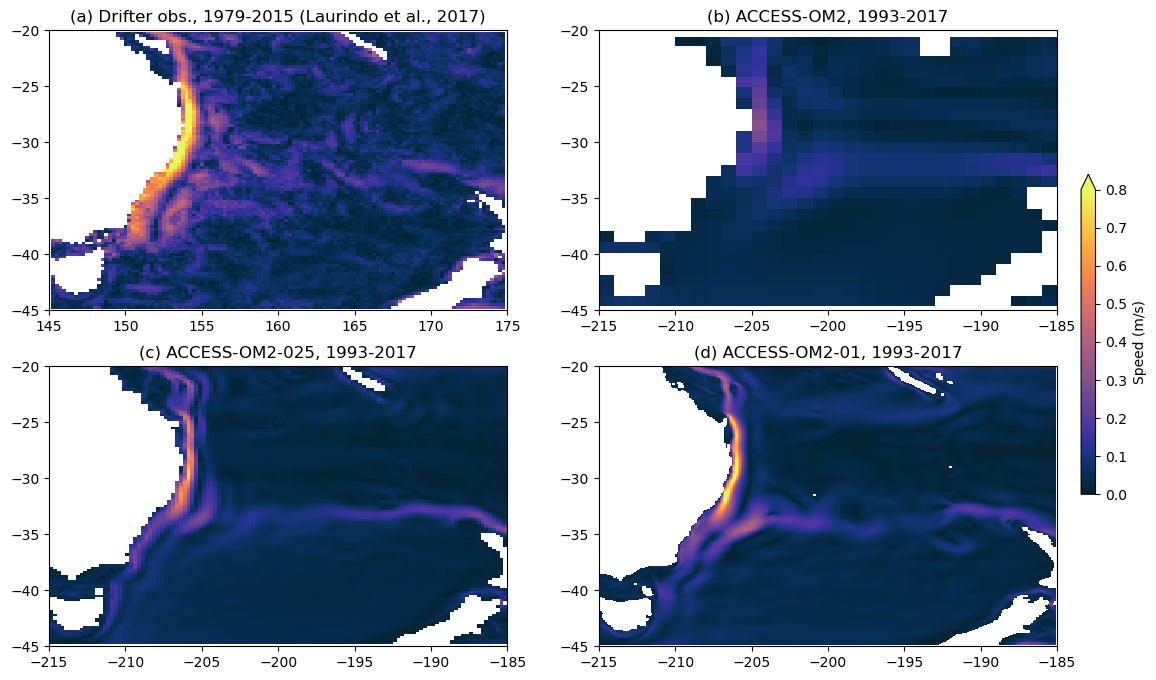

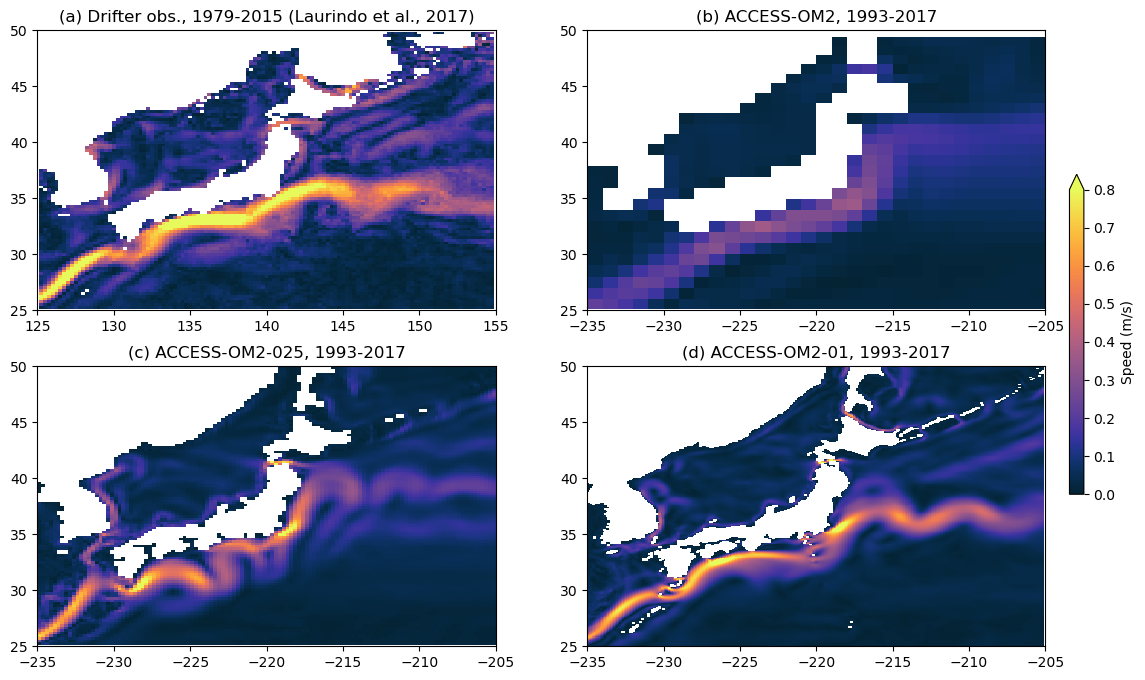

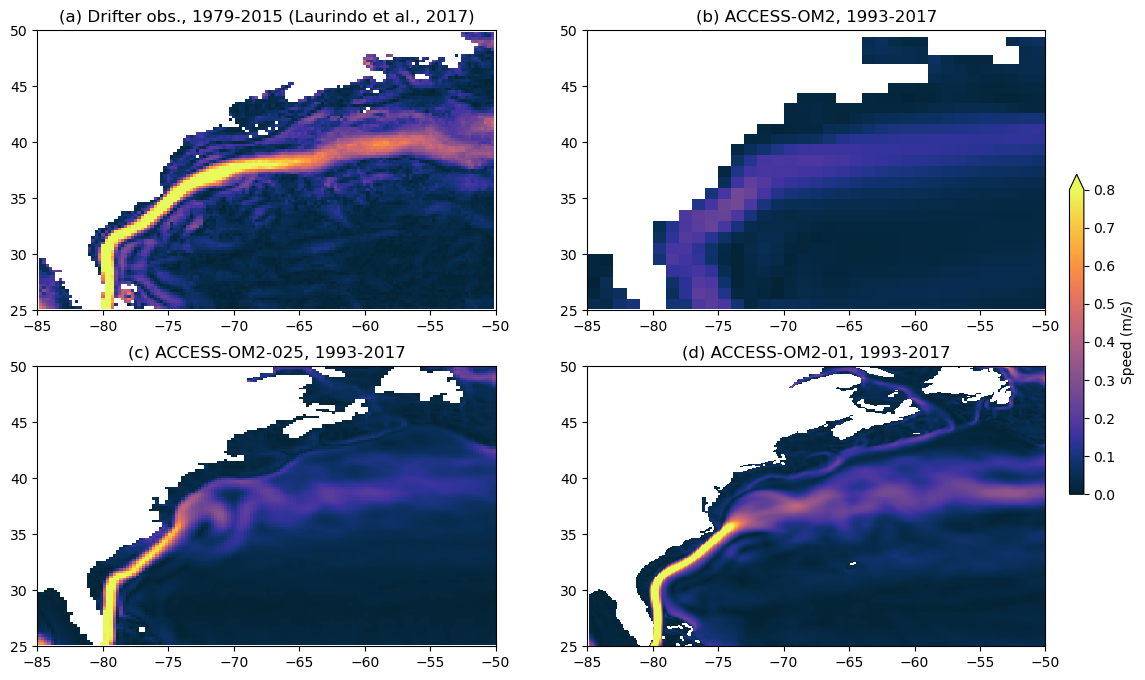

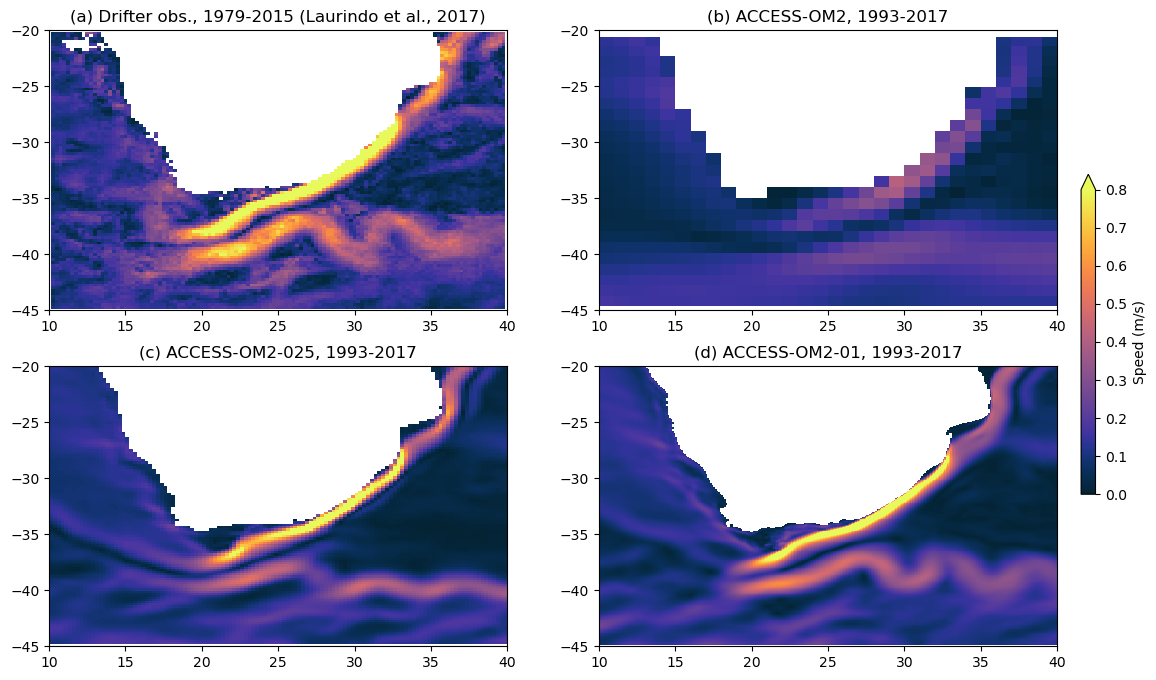

In [19]:
# plot obs and all model mean fields in each location
vmax = 0.8
ncols = 2
nrows = math.ceil((len(fields)+1)/ncols)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(12,8))
    #fig.suptitle('Observed surface current climatology and '+str(clim_years)+'-year model mean', fontsize=14)
    oloc = copy.copy(loc)
    # BUG: this probably won't work for regions that straddle 180E
    if oloc[0]<-180:
        oloc[0] = oloc[0]+360
    if oloc[1]<-180:
        oloc[1] = oloc[1]+360
    try:
        obs_speed = obs_speed.set_xindex(['longitude'])
        obs_speed = obs_speed.set_xindex(['latitude'])
    except ValueError:
        pass
    obs_speed_loc = obs_speed.sel(latitude=slice(oloc[2],oloc[3])).sel(longitude=slice(oloc[0],oloc[1]))
    ax = fig.add_subplot(ncols, nrows, 1)
    cax = ax.pcolormesh(obs_speed_loc.longitude, obs_speed_loc.latitude, np.swapaxes(obs_speed_loc,0,1)[:-1,:-1], 
                        shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
    plt.title('(a) Drifter obs., 1979-2015 (Laurindo et al., 2017)')
    plt.xlim(oloc[0],oloc[1])
    plt.ylim(oloc[2],oloc[3])

    for i, ekey in enumerate(fields.keys()):
        ax = fig.add_subplot(ncols, nrows, i+2)
        speed = fields[ekey]['speed'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
        cax = ax.pcolormesh(speed.xu_ocean, speed.yu_ocean, speed[:-1,:-1], 
                            shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
        plt.title('(' + chr(ord('a')+i+1) + ') ' + fields[ekey]['desc'] + ', ' + fields[ekey]['yearrange'])
        plt.xlim(loc[0],loc[1])
        plt.ylim(loc[2],loc[3])
    
    plt.subplots_adjust(left=0.08,right=0.92)
    ax1 = plt.axes([0.94,0.3,0.012,0.4])
    cb = plt.colorbar(cax,cax=ax1,orientation='vertical',extend='max')
    cb.ax.set_ylabel('Speed (m/s)')
    savefigure(locname+'_clim')

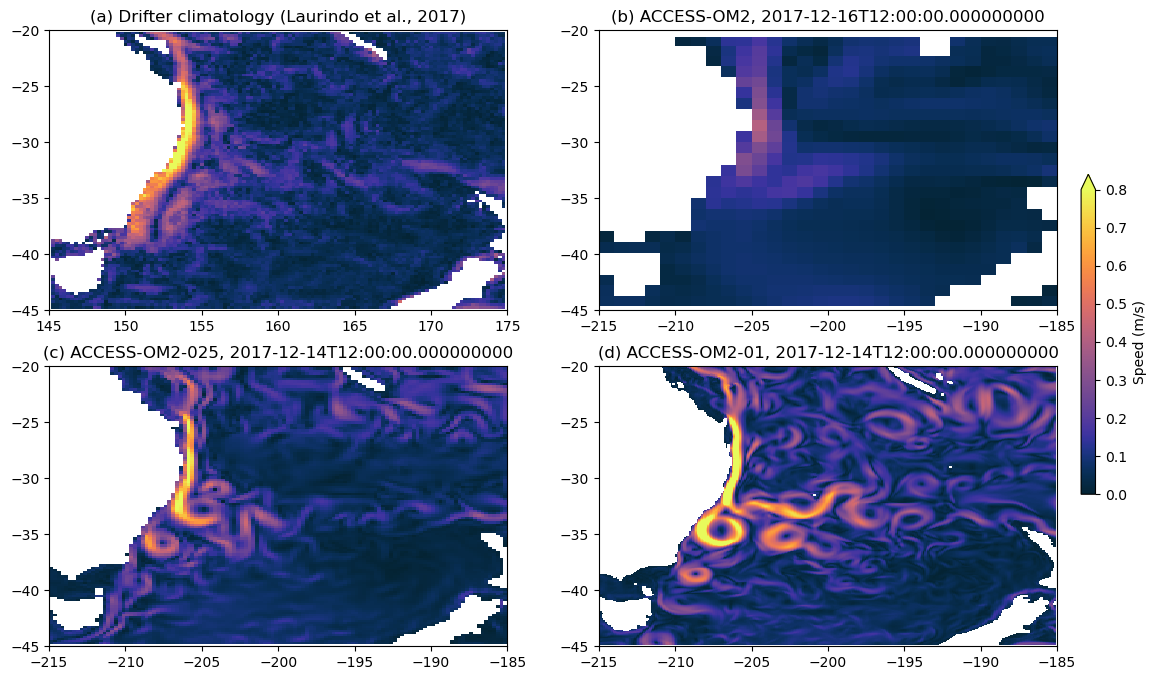

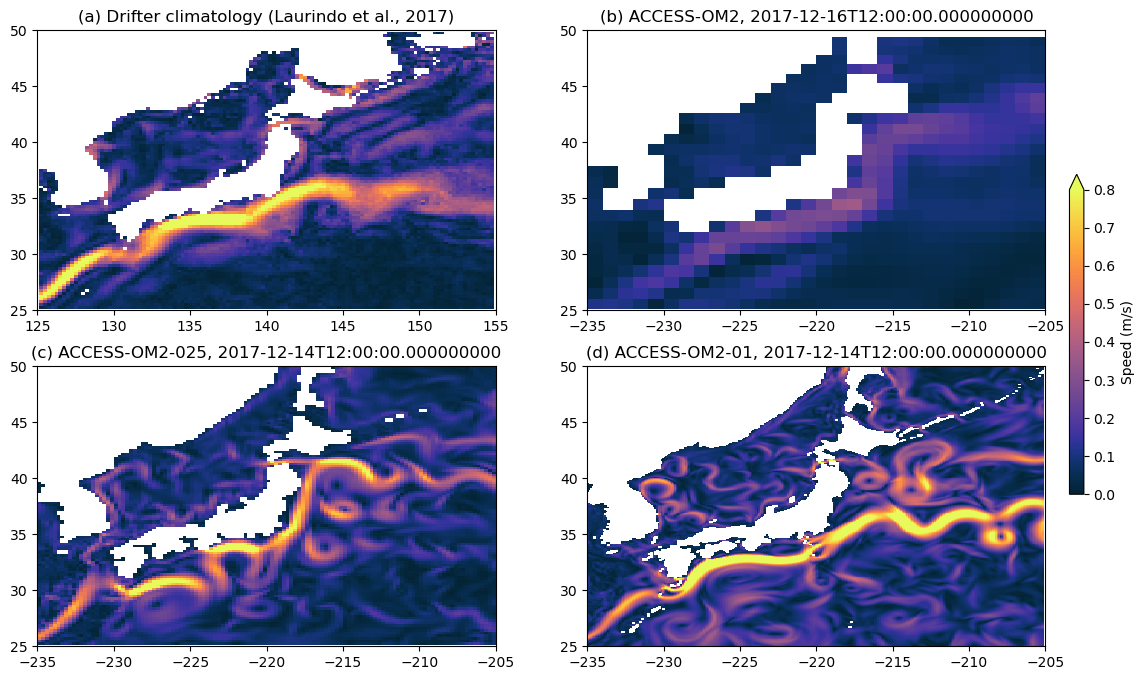

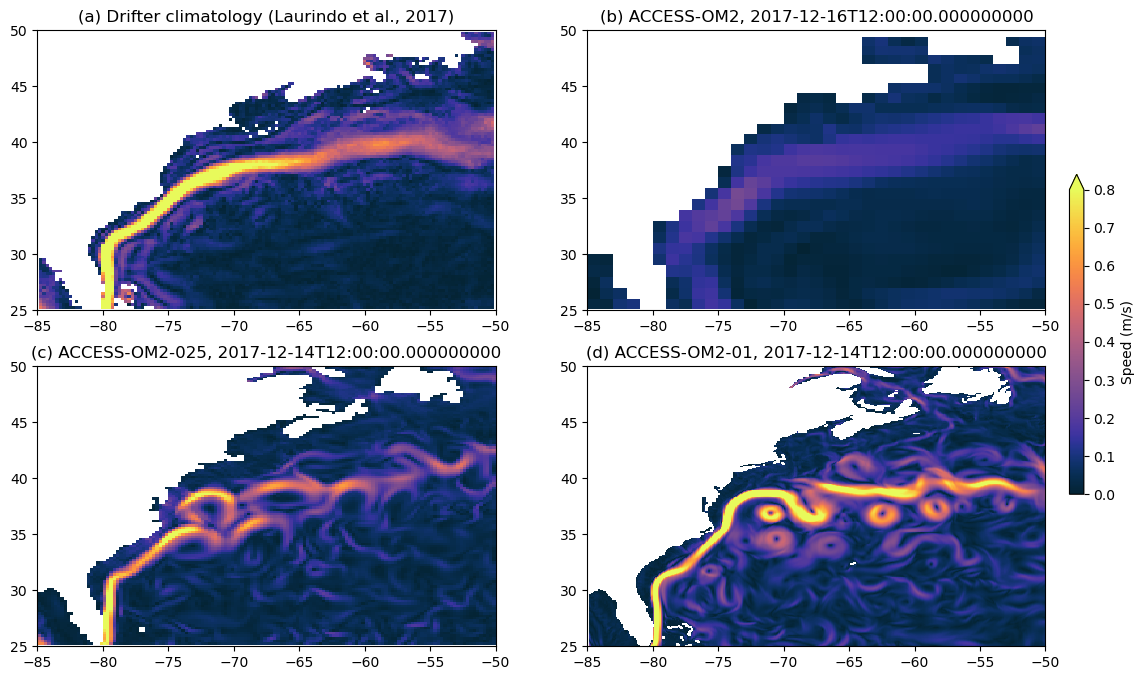

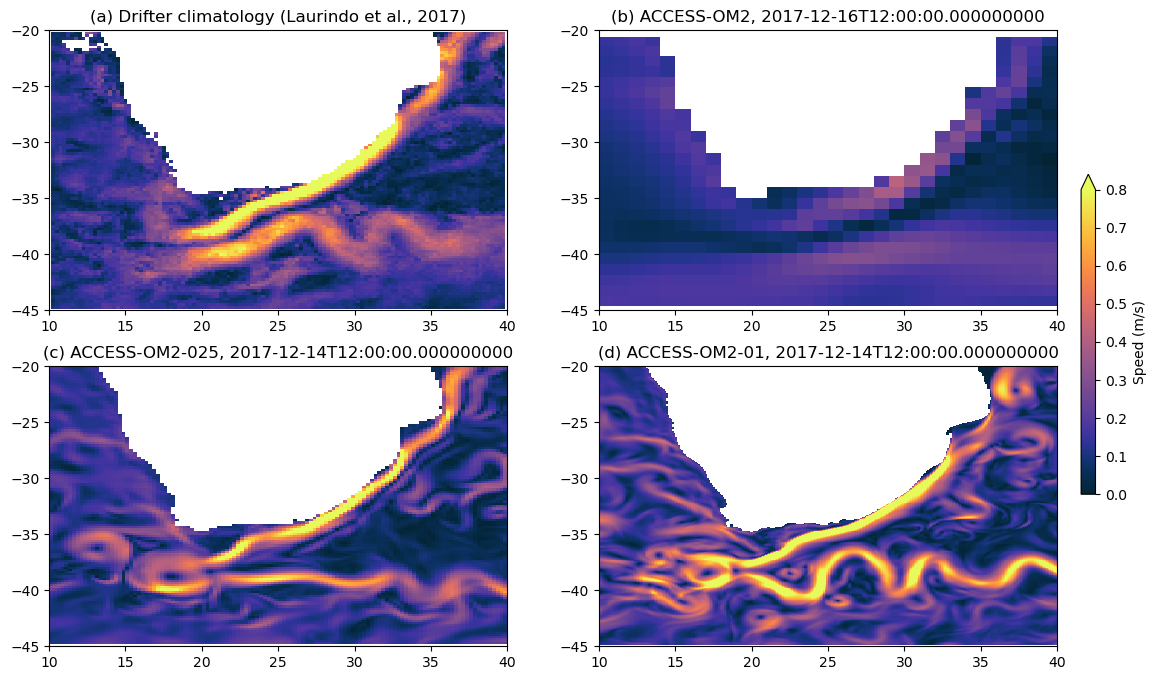

In [25]:
# plot obs and all model "snapshot" fields in each location

# NB "snapshot" is actually annual mean for 1, 0.25deg and monthly mean for 0.1deg
#   ...but could use daily surface vel from ice output at 0.1 deg if we wanted
# TODO: save daily surface vel at all resolutions
# TODO: also open final .nc file as dataset and use ds.time_bounds.astype('int64') 
#   to make title string specifying averaging date range - see ice_validation
#   ideally do this via cookbook changes: https://github.com/OceansAus/cosima-cookbook/issues/111


vmax = 0.8
ncols = 2
nrows = math.ceil((len(fields)+1)/ncols)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(12,8))
    #fig.suptitle('Observed surface current climatology and model snapshots - TODO: get 1-day snapshots from ice', fontsize=14)
    oloc = copy.copy(loc)
    # BUG: this probably won't work for regions that straddle 180E
    if oloc[0]<-180:
        oloc[0] = oloc[0]+360
    if oloc[1]<-180:
        oloc[1] = oloc[1]+360
    try:
        obs_speed = obs_speed.set_xindex(['longitude'])
        obs_speed = obs_speed.set_xindex(['latitude'])
    except ValueError:
        pass
    obs_speed_loc = obs_speed.sel(latitude=slice(oloc[2],oloc[3])).sel(longitude=slice(oloc[0],oloc[1]))
    ax = fig.add_subplot(ncols, nrows, 1)
    cax = ax.pcolormesh(obs_speed_loc.longitude, obs_speed_loc.latitude, np.swapaxes(obs_speed_loc,0,1)[:-1,:-1], 
                        shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
    plt.title('(a) Drifter climatology (Laurindo et al., 2017)', fontsize=12)
    plt.xlim(oloc[0],oloc[1])
    plt.ylim(oloc[2],oloc[3])
    #fig.colorbar(cax,shrink=0.8,label='Speed (m/s)',extend='max')

    for i, ekey in enumerate(fields.keys()):
        ax = fig.add_subplot(ncols, nrows, i+2)
        speed = fields[ekey]['speed_snap'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
        cax = ax.pcolormesh(speed.xu_ocean, speed.yu_ocean, speed[:-1,:-1], 
                            shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
        plt.title('(' + chr(ord('a')+i+1) + ') ' + str(fields[ekey]['desc']) + ', ' + str(fields[ekey]['tsnap']))
        plt.xlim(loc[0],loc[1])
        plt.ylim(loc[2],loc[3])
    
    plt.subplots_adjust(left=0.08,right=0.92)
    ax1 = plt.axes([0.94,0.3,0.012,0.4])
    cb = plt.colorbar(cax,cax=ax1,orientation='vertical',extend='max')
    cb.ax.set_ylabel('Speed (m/s)')
    
    savefigure(locname+'_snap')